In [1]:
import sys
#sys.path.append('/home/williamn/.conda/envs/ML-conda-env/lib/python3.11/site-packages')

from Data_Input import Input_Data, leaderboard_data
from Data_Processing import Basic_FE, xg_FE
from Data_Splitting import train, train_test, train_test_val
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#If things aren't working, restart kernel to force it to update imports

# Input and Split Testing

In [ ]:
# Inputs and processes data
data = Input_Data()
p_data = Basic_FE(data)


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185832 entries, 0 to 185831
Data columns (total 41 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score                  185832 non-null  float64
 12  pre_rf_x        

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(data[data["connected"]==True])

In [9]:
p_data[p_data["connected"]==True]['pre_cluster'].unique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185832 entries, 0 to 185831
Data columns (total 33 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   axonal_coor_x                   185832 non-null  int64   
 1   axonal_coor_y                   185832 non-null  int64   
 2   axonal_coor_z                   185832 non-null  int64   
 3   dendritic_coor_x                185832 non-null  int64   
 4   dendritic_coor_y                185832 non-null  int64   
 5   dendritic_coor_z                185832 non-null  int64   
 6   adp_dist                        185832 non-null  float64 
 7   post_skeletal_distance_to_soma  185832 non-null  float64 
 8   pre_skeletal_distance_to_soma   185832 non-null  float64 
 9   pre_oracle                      185832 non-null  float64 
 10  pre_test_score                  185832 non-null  float64 
 11  post_oracle                     185832 non-null  float64 
 12  po

In [ ]:
#Splits and resamples data
split = train_test(p_data, 0.2)
split.resample()

# Random Forest 

In [28]:
# random forest with random undersampling for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
#make data easier to work with
X = split.trainx
y = split.trainy
Xtest = split.testx
ytest = split.testy


In [68]:
# Setting up hyperparameters (HP's)
# Each comment and accompanying initalization defines a hyperparameter (HP) used for the construction of the model
# to include a HP delete the '##' at the beginning of the line used for the initialization of the HP 
# to exclude a HP add '##' at the beginning of the initialization line for the HP
# to add a new HP follow the convention described above and shown below
# WARNING: will need to update param grid if changes are made to prevent errors

# Number of trees in the random forest 
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 1000, num = 6)]

# Criterion used to determine quality of the split 
## criterion = ['gini', 'entropy']

# Max depth of the tree
max_depth = [int(x) for x in np.linspace(start = 2, stop = 50, num = 5)]

# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(start = 1, stop = 10, num = 3)]

# Minimum number of samples required for there to be a lead at a node
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 3)]

# Minimum weighted fractions of the sum total of all weights requried for there to be a leaf at a node
##

# Number of features considered when looking for the best split
max_features = ['sqrt', 'log2']

# Whether or not to bootstrap samples (certainly should always be done for our data set, but left here as an option)
## bootstrap = [True, False]


In [69]:
# Creating a parameter grid 
random_grid = {'n_estimators' : n_estimators,
              'max_depth'  : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf,
              'max_features' : max_features}

print(random_grid)

{'n_estimators': [50, 240, 430, 620, 810, 1000], 'max_depth': [4, 8], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'max_features': ['sqrt', 'log2']}


In [70]:
# define model
## model = BalancedRandomForestClassifier()
model = BalancedRandomForestClassifier()

In [ ]:
from sklearn.model_selection import GridSearchCV
rf_Grid = GridSearchCV(estimator = model, param_grid = random_grid, cv = 5, verbose = 2, n_jobs=4)

In [72]:
rf_Grid.fit(X, y)

Fitting 2 folds for each of 96 candidates, totalling 192 fits


c:\Users\jacob\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\jacob\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


GridSearchCV(cv=2, estimator=BalancedRandomForestClassifier(), n_jobs=4,
             param_grid={'max_depth': [4, 8], 'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 240, 430, 620, 810, 1000]},
             verbose=2)

In [67]:

y_pred = rf_Grid.predict(Xtest)
print(f"Balanced accuracy: {balanced_accuracy_score(ytest, y_pred > 0.5)}")

Balanced accuracy: 0.7782139589176853


# AdaBoost

In [10]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix

# Create AdaBoostClassifier with DecisionTreeClassifier as the base estimator
base_estimator = DecisionTreeClassifier(max_depth=1)  # Decision Stump
adaboost = AdaBoostClassifier(estimator=base_estimator, n_estimators=100, random_state=42)
adaboost.fit(split.trainx, split.trainy, )


# Predict on the test data
y_pred = adaboost.predict(split.testx)

# Calculate the accuracy
accuracy = accuracy_score(split.testy, y_pred)
print(f"Accuracy: {accuracy:.2f}")# Calculate the accuracy
accuracy = accuracy_score(split.testy, y_pred)
# confusion matrix
print(confusion_matrix(split.testy, y_pred > .5))
print(f"Accuracy: {accuracy:.2f}")
print(
    f"Balanced Accuracy: {balanced_accuracy_score(split.testy, y_pred > .5)}"
)

Accuracy: 0.72


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier  # For classification tasks
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix

gboost = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
gboost.fit(split.trainx, split.trainy)

y_pred = gboost.predict(split.testx)

accuracy = accuracy_score(split.testy, y_pred)
print(f"Accuracy: {accuracy:.2f}")# Calculate the accuracy
accuracy = accuracy_score(split.testy, y_pred)
# confusion matrix
print(confusion_matrix(split.testy, y_pred > .5))
print(f"Accuracy: {accuracy:.2f}")
print(
    f"Balanced Accuracy: {balanced_accuracy_score(split.testy, y_pred > .5)}"
)
#150 estimators, depth = 1, LR=0.05: BA = 0.781
#150 estimators, depth = 1, LR=0.03, BA = 0.776
#150 estimators, depth = 1, LR=0.05, BA = 0.78?
#200 estimators, depth = 1, LR=0.05, BA = 0.782
#150 estimators, depth = 2, LR=0.05, BA = 0.779
#120 estimators, depth = 3, LR=0.10, BA = 0.781
#120 estimators, depth = 6, LR=0.10, BA = 0.709
#200 estimators, depth = 3, LR=0.10, BA = 0.785

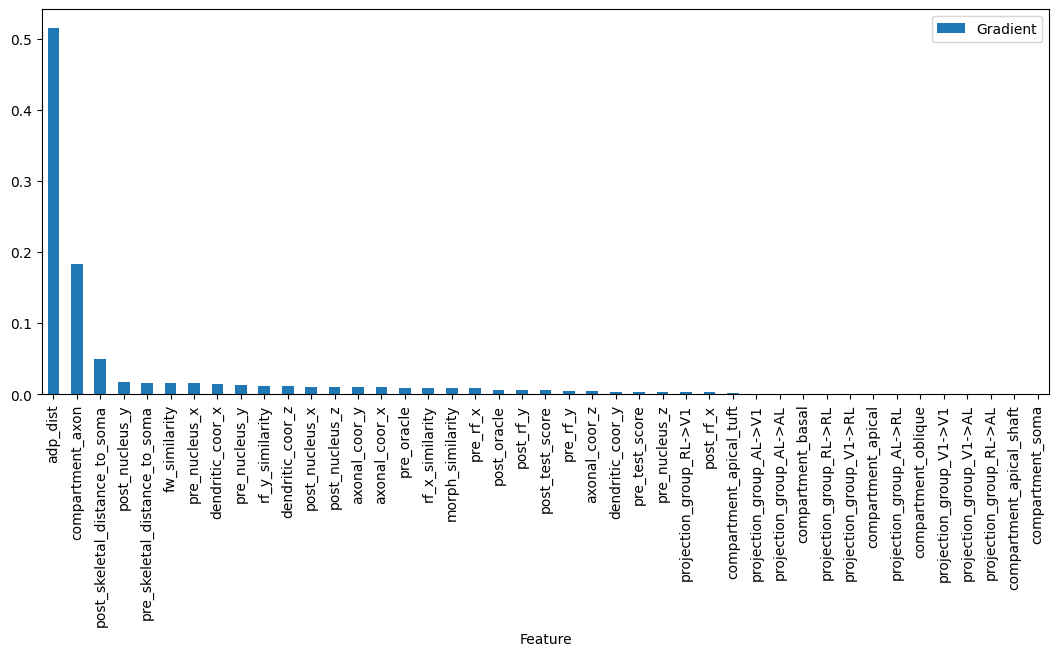

In [17]:
feature_importance = pd.DataFrame({'Feature':split.trainx.columns,'Gradient':gboost.feature_importances_})
feature_importance = feature_importance.set_index('Feature').sort_values(by='Gradient', ascending = False)
feature_importance = feature_importance/feature_importance.sum()
feature_importance.plot.bar(figsize=(13,5))
plt.show()

# XGboost

In [2]:
# XGboost process and splitting

# Inputs and processes data
data = Input_Data()
p_data = xg_FE(data)

split = train_test(p_data, 0.2)
split.resample()

/home/williamn/Rice/Classes/Intro to Machine Learning/Competition/Code/Data_Processing.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["same_cluster"] = df["same_clust"].astype("category")


## Manual search

In [15]:
#XGBoost

# Try the subsampling, bootstrapping, Hessian
# Import the path?
# Try to make custom eval_metric?

sys.path.append('/home/williamn/Software/Xgboost/xgboost/python-package/')
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Train a model using the scikit-learn API

#xgb_classifier = xgb.XGBClassifier(n_estimators=60, objective='binary:logistic', tree_method='hist', eta=0.1, max_depth=3, enable_categorical=True)
#1000, hist, 0.005, 4
xgb_classifier = xgb.XGBClassifier(n_estimators=2500,
                                   objective='binary:logistic',
                                   tree_method='hist',
                                   eta=0.06,
                                   max_depth=1,
                                   enable_categorical=True,
                                   verbosity=1,
                                   eval_metric = balanced_accuracy_score,
                                   min_child_weight = 200,
                                   max_bin = 400,
                                   subsample = 1.0,
                                   colsample_by_tree=0.5,
                                  )
xgb_classifier.fit(split.trainx, split.trainy)

y_pred = xgb_classifier.predict(split.testx)

accuracy = accuracy_score(split.testy, y_pred)
# confusion matrix
print(confusion_matrix(split.testy, y_pred > .5))
print(f"Accuracy: {accuracy:.2f}")
print(
    f"Balanced Accuracy: {balanced_accuracy_score(split.testy, y_pred > .5)}"
)

# Convert the model to a native API model
model = xgb_classifier.get_booster()

[21:39:35] WARNING: /home/williamn/Software/Xgboost/xgboost/src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[[26856 10051]
 [   35   225]]
Accuracy: 0.73
Balanced Accuracy: 0.7965257268268893


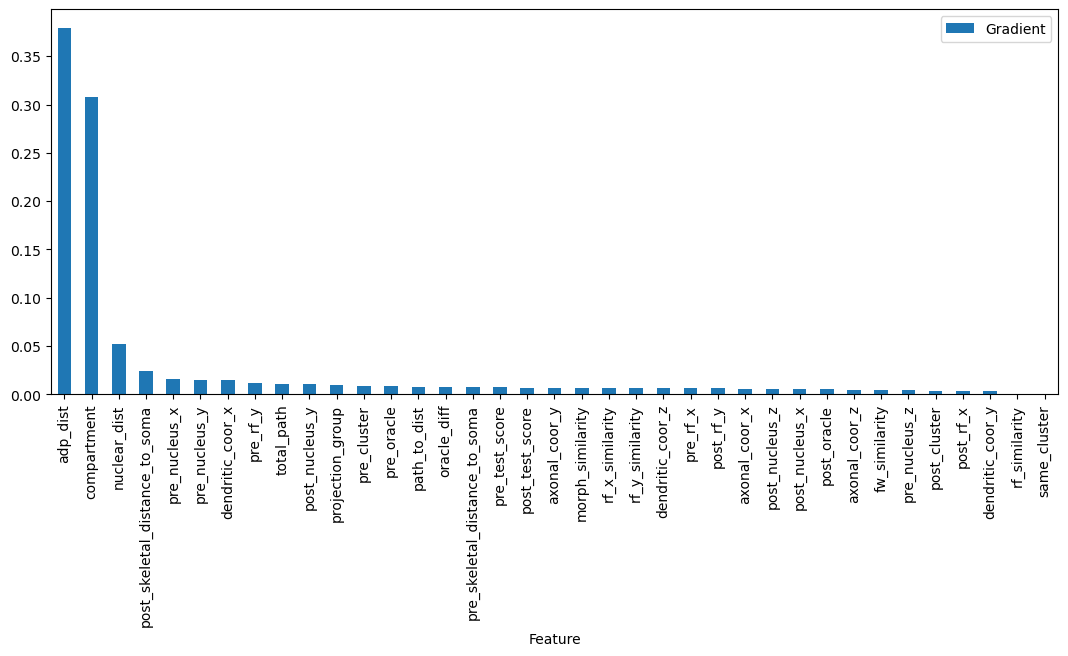

In [26]:
feature_importance = pd.DataFrame({'Feature':split.trainx.columns,'Gradient':xgb_classifier.feature_importances_})
feature_importance = feature_importance.set_index('Feature').sort_values(by='Gradient', ascending = False)
feature_importance = feature_importance/feature_importance.sum()
feature_importance.plot.bar(figsize=(13,5))
plt.show()

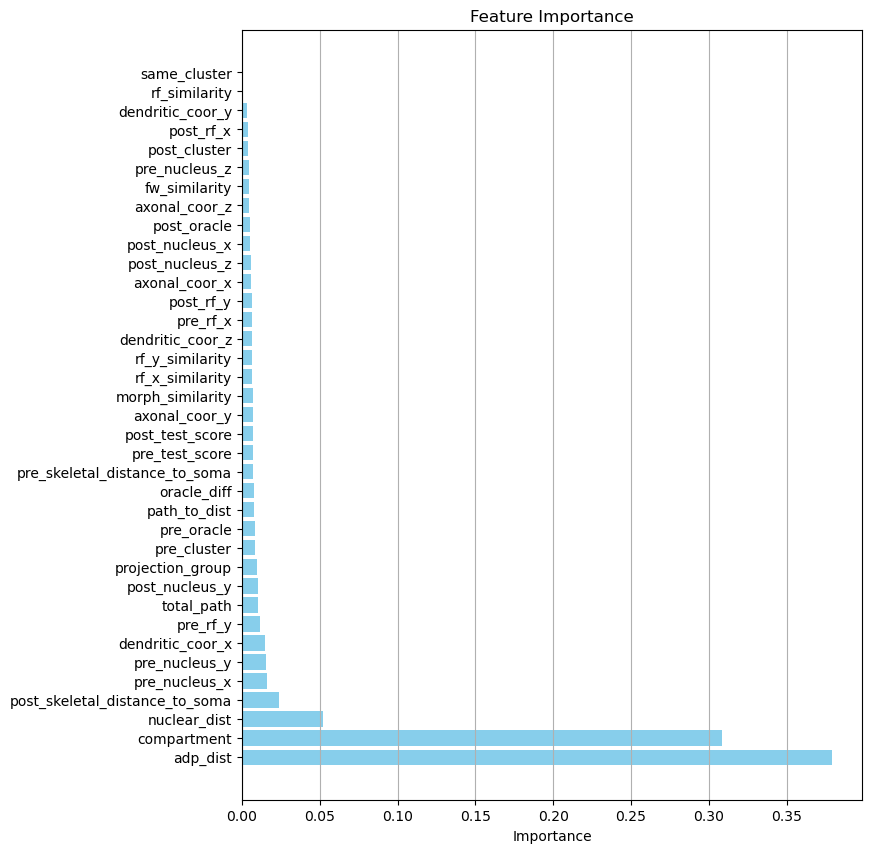

In [27]:
# Sort the data and normalize the values
feature_importance = feature_importance.sort_values(by='Gradient', ascending=False)
feature_importance = feature_importance / feature_importance.sum()

# Create a vertical bar chart with bar labels on the y-axis
plt.figure(figsize=(8, 10))  # Adjust the figure size as needed
plt.barh(feature_importance.index, feature_importance['Gradient'], color='skyblue')
plt.xlabel('Importance')  # Label for the left/right axis
plt.title('Feature Importance')  # Chart title
plt.grid(axis='x')  # Add gridlines for better readability

plt.show()


## Grid search

In [ ]:
# Grid search
# Number of estimator
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 2000, num = 4)]

# Max depth of the tree
max_depth = [int(x) for x in np.linspace(start = 1, stop = 4, num = 4)]

# Training speed
eta = [float(x) for x in np.linspace(start = 0.01, stop = 0.1, num = 4)]

# Growth Policy
grow_policy = ['depthwise', 'lossguide']
boost_grid = {'n_estimators' : n_estimators,
              'max_depth'  : max_depth,
              'eta' : eta,
              'grow_policy' : grow_policy,
              }
print(boost_grid)
model = xgb.XGBClassifier(objective='binary:logistic',
                            tree_method='hist',
                            eval_metric = balanced_accuracy_score,
                            enable_categorical=True,
)
rf_Grid = RandomSearchCV(estimator = model, param_grid = boost_grid, cv = 2, verbose = 2, scoring="balanced_accuracy")


In [ ]:
rf_Grid.fit(split.trainx, split.trainy)

In [46]:
y_pred = rf_Grid.predict(split.testx)

print(
    f"Balanced Accuracy: {balanced_accuracy_score(split.testy, y_pred > .5)}"
)
print(confusion_matrix(split.testy, y_pred > .5))
print(f"Accuracy: {accuracy:.2f}")
#73% non-axon accuracy w/o axon
#75% non-axon accuracy w/ axon
rf_Grid.best_params_

Balanced Accuracy: 0.5320895494026493
[[36541   355]
 [  251    20]]
Accuracy: 0.65


{'eta': 0.1, 'grow_policy': 'depthwise', 'max_depth': 4, 'n_estimators': 2000}

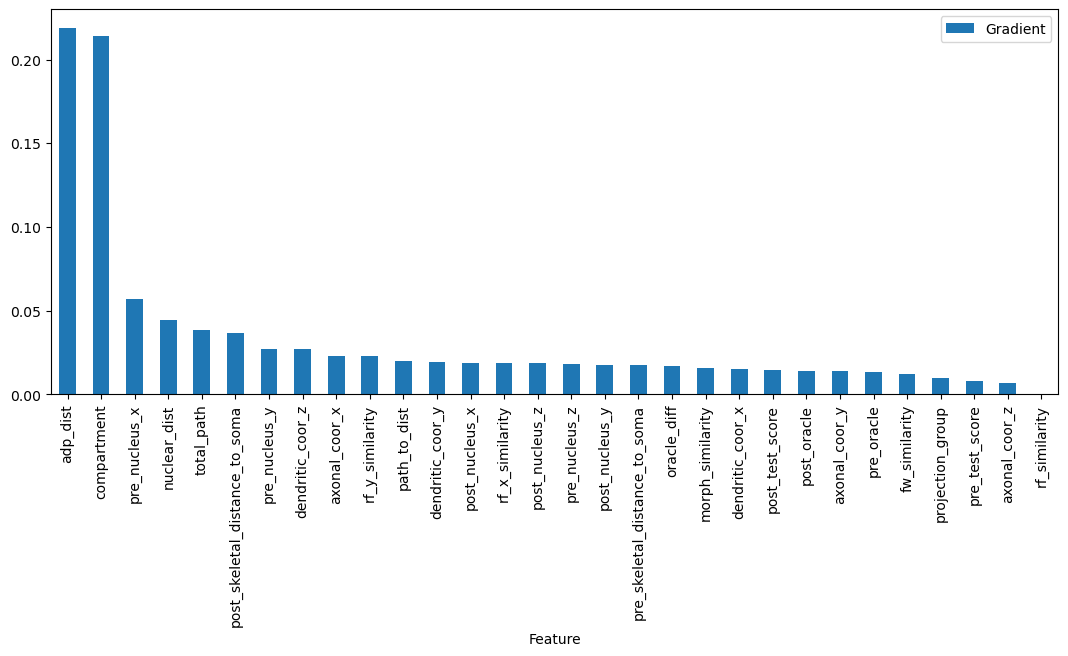

In [25]:
feature_importance = pd.DataFrame({'Feature':split.trainx.columns,'Gradient':xgb_classifier.feature_importances_})
feature_importance = feature_importance.set_index('Feature').sort_values(by='Gradient', ascending = False)
feature_importance = feature_importance/feature_importance.sum()
feature_importance.plot.bar(figsize=(13,5))
plt.show()

## Custom Search

In [3]:
data = Input_Data()
p_data = xg_FE(data)

/home/williamn/Rice/Classes/Intro to Machine Learning/Competition/Code/Data_Processing.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["same_cluster"] = df["same_clust"].astype("category")


In [4]:
split = train_test_val(p_data,0.2,0.2)
split.resample()

In [103]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix, mean_absolute_error
sys.path.append('/home/williamn/Software/Xgboost/xgboost/python-package/')
import xgboost as xgb
from xgboost import XGBClassifier
from time import time

In [9]:
from itertools import product

n_estimators = [700,2500,3000,3500]
objective = ['binary:logistic']
tree_method = ['hist']
eta = [0.04, 0.06, 0.07]
max_depth = [1,2]
enable_categorical=[True]
eval_metric = [balanced_accuracy_score]
verbosity = [0]
min_child_weight = [1, 15, 200]
max_bin = [100, 256, 400]
subsample = [0.25, 0.5, 1]
colsample_bytree = [0.5, 1]


Hyperparam_Dict = {
    "n_estimators" : n_estimators,
    "objective" : objective,
    "tree_method" : tree_method,
    "eta" : eta,
    "max_depth" : max_depth,
    "enable_categorical" : enable_categorical,
    "eval_metric" : eval_metric,
    "verbosity" : verbosity,
    "min_child_weight": min_child_weight,
    "max_bin" : max_bin,
    "subsample" : subsample,
    "colsample_bytree" : colsample_bytree,
}

In [ ]:
combinations = list(product(*Hyperparam_Dict.values()))
combo_n_score = []

print(len(combinations))
count = 0

totaltime = time()
for combo in combinations:
    start = time()
    combo_dict = {key:value for key, value in zip(Hyperparam_Dict.keys(), combo)}
    xgb_classifier = xgb.XGBClassifier(
                                   n_estimators=combo_dict["n_estimators"],
                                   objective=combo_dict["objective"],
                                   tree_method=combo_dict["tree_method"],
                                   eta=combo_dict["eta"],
                                   max_depth=combo_dict["max_depth"],
                                   enable_categorical=combo_dict["enable_categorical"],
                                   eval_metric =combo_dict["eval_metric"],
                                   verbosity=combo_dict["verbosity"],
                                   min_child_weight = combo_dict["min_child_weight"],
                                   max_bin = combo_dict["max_bin"],
                                   subsample = combo_dict["subsample"],
                                   colsample_bytree = combo_dict["colsample_bytree"]
                                      )
    xgb_classifier.fit(split.trainx, split.trainy)

    y_pred = xgb_classifier.predict(split.valx)
    acc = accuracy_score(split.valy, y_pred)
    b_acc = balanced_accuracy_score(split.valy , y_pred > .5)
    
    y_pred = xgb_classifier.predict(split.testx)
    t_acc = accuracy_score(split.testy, y_pred)
    tb_acc = balanced_accuracy_score(split.testy , y_pred > .5)
    
    combo_n_score.append([combo_dict,acc,b_acc,t_acc,tb_acc])
    count += 1
    train_time = time() - start
    print(f"{count:4d}/{len(combinations):4d}, NE:{combo_dict['n_estimators']:4d}, D:{combo_dict['max_depth']:2d}, Et:{combo_dict['eta']:.4f}, MC:{combo_dict['min_child_weight']:3d}, MB:{combo_dict['max_bin']:4d}, S:{combo_dict['subsample']:.4f}, CS:{combo_dict['colsample_bytree']:.2f}, Acc:{acc:.4f}, BAcc: {b_acc:.4f}, TAc:{t_acc:.4f}, TBAc: {tb_acc:.4f}, T:{train_time:.2f} ETA:{train_time*(len(combinations)-count):.2f}")



In [7]:
import csv

In [12]:
# Write hyperparameter tuning results to a CSV
file_name = 'Hyperparams_1.csv'
with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(combo_n_score)
    

In [9]:
import json
import ast

In [10]:
test = []
file_name = 'Hyperparams_1.csv'
with open(file_name, mode='r',encoding='utf-8-sig') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        if row == []:
            continue
        string_data = row[0]
       # # Replace the function reference with its name (assuming it's imported)
        string_data = string_data.replace('<function balanced_accuracy_score at 0x7f24b437a700>', "\"balanced_accuracy_score\"")
       # # Replace single quotes with double quotes to make it a valid JSON-like string
        string_data = string_data.replace("'", '"')
       # # Safely evaluate the string as a Python literal using ast.literal_eval
        parsed_dict = ast.literal_eval(string_data)
        row[0] = parsed_dict
        test.append(row)

In [11]:
hyp_dicts = []
for item in test:
    newdict = item[0]
    newdict['Acc']   = float(item[1])
    newdict['BAcc']  = float(item[2])
    newdict['TAcc']  = float(item[3])
    newdict['TBAcc'] = float(item[4])
    hyp_dicts.append(newdict)
df = pd.DataFrame(hyp_dicts)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   n_estimators        1296 non-null   int64  
 1   objective           1296 non-null   object 
 2   tree_method         1296 non-null   object 
 3   eta                 1296 non-null   float64
 4   max_depth           1296 non-null   int64  
 5   enable_categorical  1296 non-null   bool   
 6   eval_metric         1296 non-null   object 
 7   verbosity           1296 non-null   int64  
 8   min_child_weight    1296 non-null   int64  
 9   max_bin             1296 non-null   int64  
 10  subsample           1296 non-null   float64
 11  colsample_bytree    1296 non-null   float64
 12  Acc                 1296 non-null   float64
 13  BAcc                1296 non-null   float64
 14  TAcc                1296 non-null   float64
 15  TBAcc               1296 non-null   float64
dtypes: boo

## Visualization

In [19]:
import seaborn as sns

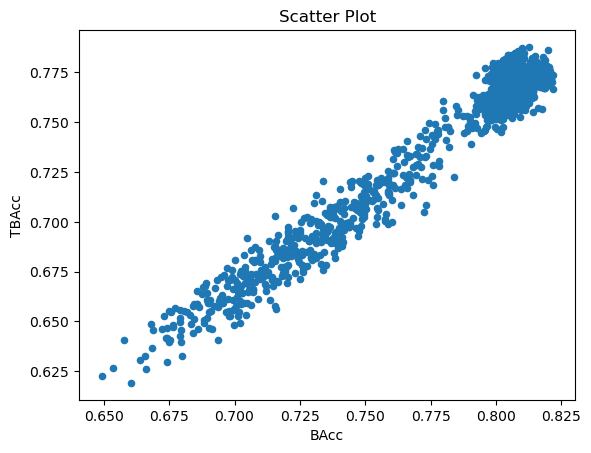

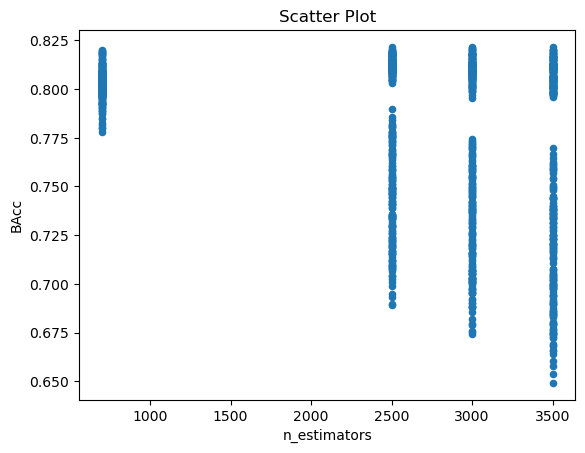

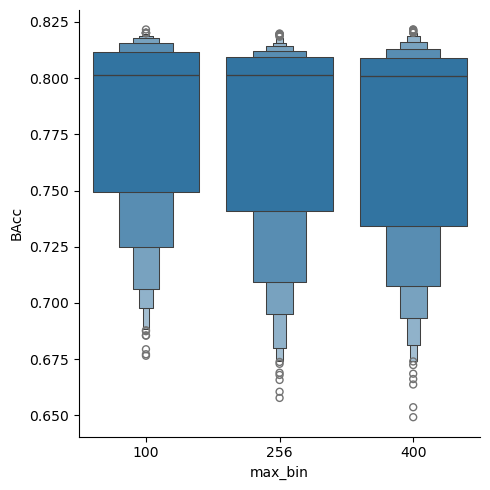

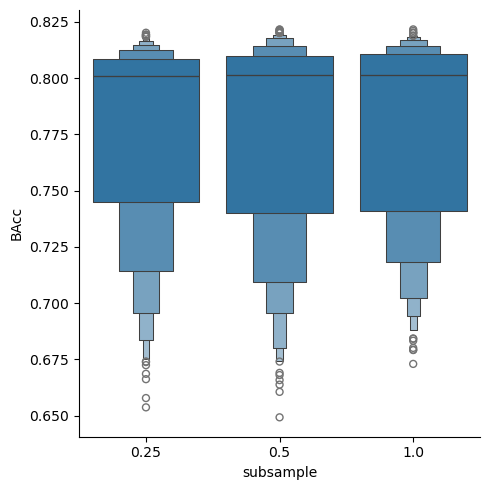

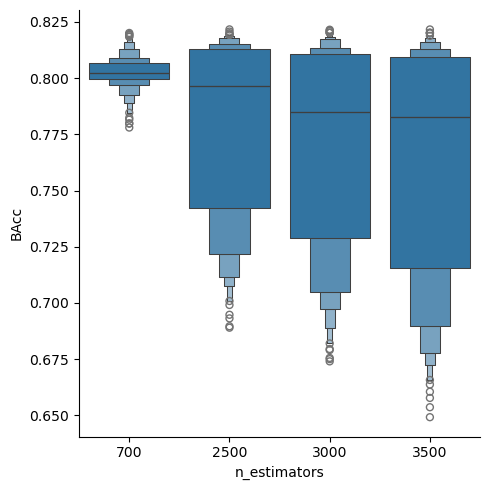

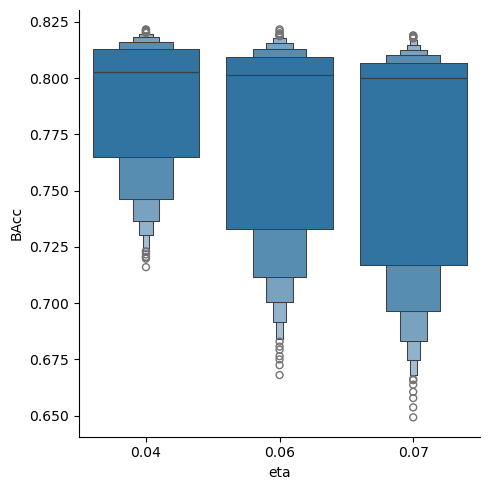

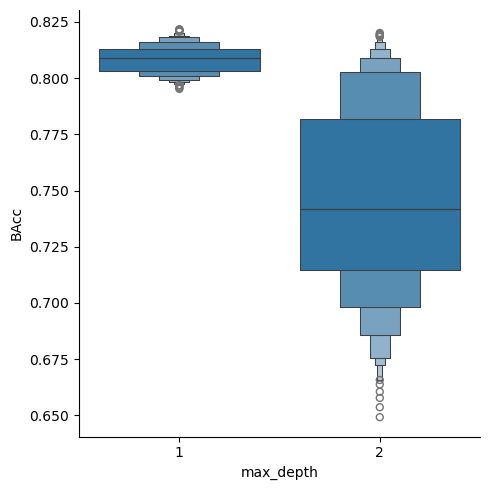

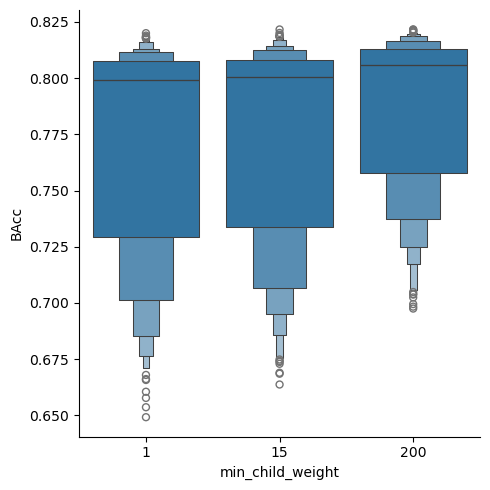

In [24]:
df.plot.scatter(x='BAcc', y='TBAcc', title='Scatter Plot')
plt.xlabel('BAcc')
plt.ylabel('TBAcc')
plt.show()

df.plot.scatter(x='n_estimators', y='BAcc', title='Scatter Plot')
plt.xlabel('n_estimators')
plt.ylabel('BAcc')
plt.show()


sns.catplot(data=df, x='max_bin', y='BAcc', kind='boxen')

sns.catplot(data=df, x='subsample', y='BAcc', kind='boxen')

sns.catplot(data=df, x='n_estimators', y='BAcc', kind='boxen')

sns.catplot(data=df, x='eta', y='BAcc', kind='boxen')

sns.catplot(data=df, x='max_depth', y='BAcc', kind='boxen')

sns.catplot(data=df, x='min_child_weight', y='BAcc', kind='boxen')


#Lower eta better? Max depth 1 best?

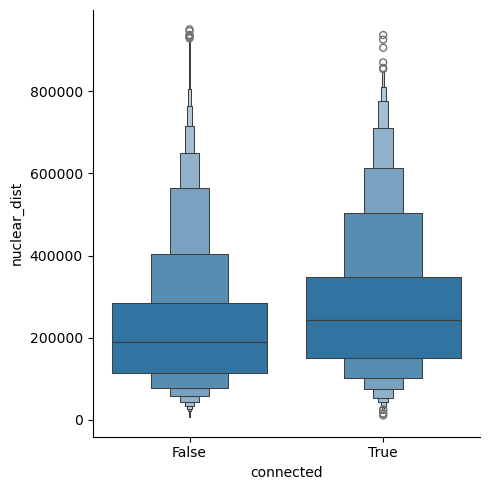

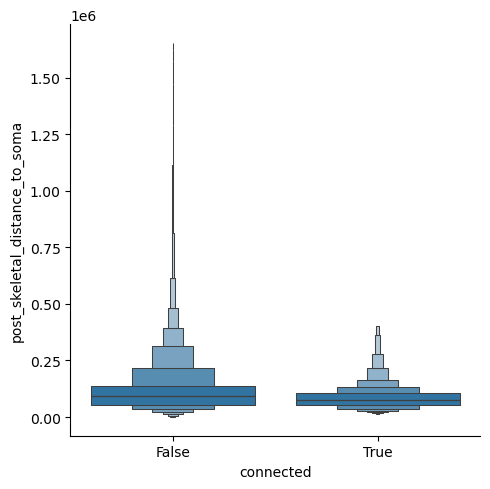

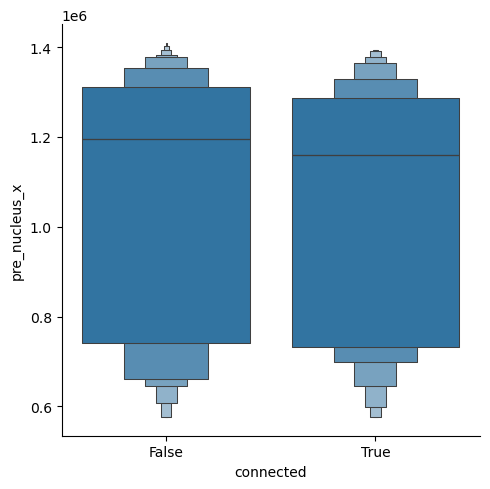

In [35]:
#sns.scatterplot(data=p_data, x='nuclear_dist', y='connected')
sns.catplot(data=p_data, x='connected', y='nuclear_dist', kind='boxen')
sns.catplot(data=p_data, x='connected', y='post_skeletal_distance_to_soma', kind='boxen',showfliers=False)
sns.catplot(data=p_data, x='connected', y='pre_nucleus_x', kind='boxen',showfliers=False)


## Performance Investigation

In [97]:
max_score_row = df.loc[df['BAcc'].idxmax()]

In [98]:
max_score_row

n_estimators                             2500
objective                     binary:logistic
tree_method                              hist
eta                                      0.06
max_depth                                   1
enable_categorical                       True
eval_metric           balanced_accuracy_score
verbosity                                   0
min_child_weight                          200
max_bin                                   400
subsample                                 1.0
colsample_bytree                          0.5
Acc                                  0.724533
BAcc                                 0.821646
TAcc                                 0.723168
TBAcc                                0.773776
Name: 484, dtype: object

In [ ]:
# Updating existing dictionaries in list_of_parameters with scores
combo_copy = combinations
combo_dicts = []
for combo in combo_copy:
    combo_dict = {key:value for key, value in zip(Hyperparam_Dict.keys(), combo)}
    combo_dicts.append(combo_dict)
for params, combo_n_score in zip(combo_dicts, combo_n_score):
    params['Acc'] = combo_n_score[1]
    params['BAcc'] = combo_n_score[2]
    params['TAcc'] = combo_n_score[3]
    params['TBAcc'] = combo_n_score[4]


In [24]:
max_b_acc = max(item[2] for item in combo_n_score)
max_b_acc_index = [index for index, item in enumerate(combo_n_score) if item[2] == max_b_acc]

max_tb_acc = max(item[4] for item in combo_n_score)
max_tb_acc_index = [index for index, item in enumerate(combo_n_score) if item[4] == max_tb_acc]

max_db_acc = max(((item[4]+item[2])/2) for item in combo_n_score)
max_db_acc_index = [index for index, item in enumerate(combo_n_score) if (item[4]+item[2])/2 == max_db_acc]

print(max_b_acc)
print(combo_n_score[max_b_acc_index[0]])

print(max_tb_acc)
print(combo_n_score[max_tb_acc_index[0]])

print(max_db_acc)
print(combo_n_score[max_db_acc_index[0]])

0.7734466225412622
[{'n_estimators': 100, 'objective': 'binary:logistic', 'tree_method': 'hist', 'eta': 0.001, 'max_depth': 2, 'enable_categorical': True, 'eval_metric': <function balanced_accuracy_score at 0x7f4c81e925c0>, 'verbosity': 0}, 0.6474465909702416, 0.7734466225412622, 0.6462453251540345, 0.7753997569056454]
0.7753997569056454
[{'n_estimators': 100, 'objective': 'binary:logistic', 'tree_method': 'hist', 'eta': 0.001, 'max_depth': 2, 'enable_categorical': True, 'eval_metric': <function balanced_accuracy_score at 0x7f4c81e925c0>, 'verbosity': 0}, 0.6474465909702416, 0.7734466225412622, 0.6462453251540345, 0.7753997569056454]
0.7744231897234538
[{'n_estimators': 100, 'objective': 'binary:logistic', 'tree_method': 'hist', 'eta': 0.001, 'max_depth': 2, 'enable_categorical': True, 'eval_metric': <function balanced_accuracy_score at 0x7f4c81e925c0>, 'verbosity': 0}, 0.6474465909702416, 0.7734466225412622, 0.6462453251540345, 0.7753997569056454]


In [114]:
max_score_row

n_estimators                             2500
objective                     binary:logistic
tree_method                              hist
eta                                      0.06
max_depth                                   1
enable_categorical                       True
eval_metric           balanced_accuracy_score
verbosity                                   0
min_child_weight                          200
max_bin                                   400
subsample                                 1.0
colsample_bytree                          0.5
Acc                                  0.724533
BAcc                                 0.821646
TAcc                                 0.723168
TBAcc                                0.773776
Name: 484, dtype: object

In [117]:

xgb_classifier = xgb.XGBClassifier(
                               n_estimators=2500,
                               objective="binary:logistic",
                               tree_method="hist",
                               eta=0.06,
                               max_depth=1,
                               enable_categorical=True,
                               eval_metric = balanced_accuracy_score,
                               verbosity=0,
                               min_child_weight = 200,
                               max_bin = 400,
                               subsample = 1,
                               colsample_bytree = 0.5
                                  )


In [115]:
combo_dict = max_score_row

xgb_classifier = xgb.XGBClassifier(
                               n_estimators=combo_dict["n_estimators"],
                               objective=combo_dict["objective"],
                               tree_method=combo_dict["tree_method"],
                               eta=combo_dict["eta"],
                               max_depth=combo_dict["max_depth"],
                               enable_categorical=combo_dict["enable_categorical"],
                               eval_metric = balanced_accuracy_score,
                               verbosity=combo_dict["verbosity"],
                               min_child_weight = combo_dict["min_child_weight"],
                               max_bin = combo_dict["max_bin"],
                               subsample = combo_dict["subsample"],
                               colsample_bytree = combo_dict["colsample_bytree"]
                                  )


In [118]:
train_val_x = pd.concat([split.trainx,split.valx])
train_val_y = pd.concat([split.trainy,split.valy])

xgb_classifier.fit(train_val_x, train_val_y)

y_pred = xgb_classifier.predict(split.testx)
acc = accuracy_score(split.testy, y_pred)
b_acc = balanced_accuracy_score(split.testy , y_pred > .5)

print(f"Num: {count:4d}, Estimators: {combo_dict['n_estimators']:4d}, Depth: {combo_dict['max_depth']:2d}, Eta: {combo_dict['eta']:.4f}, Acc:{acc:.4f}, BAcc: {b_acc:.4f}")

Num: 1296, Estimators: 2500, Depth:  1, Eta: 0.0600, Acc:0.7693, BAcc: 0.7675


# Submission

In [120]:
lb_data = leaderboard_data()

## Submission BRF

In [35]:
# Submission BRF
submission_BRF_model = BalancedRandomForestClassifier(max_depth=38, max_features='log2',min_samples_leaf=1,min_samples_split=5,n_estimators=50)

IDs = lb_data["ID"]
lb_data = Basic_FE(lb_data)
#lb_data = xg_FE(lb_data)
# oversample connected neuron pairs for full training data

data = Input_Data()
train_data = Basic_FE(data)
#train_data = xg_FE(data)
train_data = train_test(train_data)
train_data.resample()

# fit model
#adaboost.fit(train_data.trainx, train_data.trainy)
#gboost.fit(train_data.trainx, train_data.trainy)
#xgb_classifier.fit(train_data.trainx, train_data.trainy)
submission_BRF_model.fit(train_data.trainx, train_data.trainy)

# predict on leaderboard data
#lb_data["pred"] = pipe.predict_proba(lb_data[["fw_similarity", "adp_dist"]])[:, 1]
#lb_data["pred"] = gboost.predict(lb_data)
#lb_data["pred"] = xgb_classifier.predict(lb_data)
lb_data["pred"] = submission_BRF_model.predict(lb_data)

lb_data["ID"]=IDs

#create a boolean prediction solution
lb_data["connected"] = lb_data["pred"] > .5

#columns should be ID, connected
submission_data = lb_data.filter(['ID','connected'])
submission_data.info()

/home/williamn/.conda/envs/ML-conda-env/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/williamn/.conda/envs/ML-conda-env/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


<class 'pandas.core.frame.DataFrame'>
Int64Index: 42593 entries, 0 to 42592
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         42593 non-null  int64
 1   connected  42593 non-null  bool 
dtypes: bool(1), int64(1)
memory usage: 707.1 KB


## Submission XGboost

In [121]:
# Submission XGboost
IDs = lb_data["ID"]
lb_data = xg_FE(lb_data)
# oversample connected neuron pairs for full training data

data = Input_Data()
train_data = xg_FE(data)
train_data = train(train_data)
train_data.resample()

# fit model
xgb_classifier.fit(train_data.trainx, train_data.trainy)

# predict on leaderboard data
lb_data["pred"] = xgb_classifier.predict(lb_data)

lb_data["ID"]=IDs

#create a boolean prediction solution
lb_data["connected"] = lb_data["pred"] > .5

#columns should be ID, connected
submission_data = lb_data.filter(['ID','connected'])
submission_data.info()

/home/williamn/Rice/Classes/Intro to Machine Learning/Competition/Code/Data_Processing.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["same_cluster"] = df["same_clust"].astype("category")
/home/williamn/Rice/Classes/Intro to Machine Learning/Competition/Code/Data_Processing.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["same_cluster"] = df["same_clust"].astype("category")


<class 'pandas.core.frame.DataFrame'>
Int64Index: 42593 entries, 0 to 42592
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         42593 non-null  int64
 1   connected  42593 non-null  bool 
dtypes: bool(1), int64(1)
memory usage: 707.1 KB


# Output Writing

In [122]:
#writing csv files
submission_data.to_csv('Submission_Name.csv',index=False)